In [1]:
# Import libraries

import glob
from collections import Counter
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

import os
import sys
import psutil
import gc
import pickle

In [2]:
# Import datasets
from helpers import *
DEBUG = False
otto = OTTO(debug=DEBUG)
data = otto.data

# for easier development
train = data['train']
val = data['val']
val_true = data['val_true']
types = data['types']
candidates = data['candidates']

# EDA

In [3]:
# Show column names
print('Column names in train and validation datasets:')
for col in train.columns:
    print(col)

# The sizes of train and validation sets
print('')
print('The size of train and validation datasets: ')
for item in train,val:
    print(item.shape)

# Unique session indices and aid
print(' ')
n_sid = train['session'].nunique()
n_aid = train['aid'].nunique()
print('The number of unique sessions in the train dataset: {}'.format(n_sid))
print('The number of unique items in the train dataset: {}'.format(n_aid))

Column names in train and validation datasets:
session
aid
ts
type

The size of train and validation datasets: 
(1359885, 4)
(1181359, 4)
 
The number of unique sessions in the train dataset: 300000
The number of unique items in the train dataset: 330392


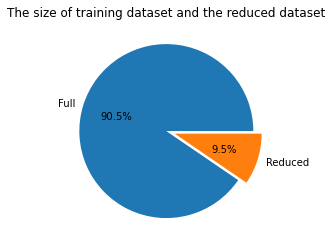

The original train size is huge.
In this notebook, we used the reduced trainset for exploration and training.


In [170]:
original_train_size = 12899779
sizes = [original_train_size, train.shape[0]]
sizes = sizes / np.sum(sizes)
fig,ax = plt.subplots()
labels = ['Full', 'Reduced']
explode = [0, 0.1]
ax.pie(sizes, labels=labels, autopct='%1.1f%%', explode=explode)
plt.title('The size of training dataset and the reduced dataset')
plt.show()
print('The original train size is huge.') 
print('In this notebook, we used the reduced trainset for exploration and training.')

Most events in the train dataset are "clicks".


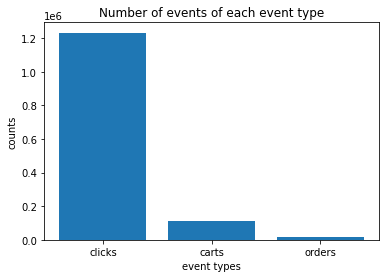

In [5]:
# Counts of each event_type
counts = train.groupby('type').count()['session'].sort_values(ascending=False)
plt.bar(counts.index, counts.to_list())
plt.xlabel('event types')
plt.ylabel('counts')
plt.title('Number of events of each event type')
print('Most events in the train dataset are "clicks".')

Most sessions have less than 10 events.


Text(0, 0.5, 'counts of unique session')

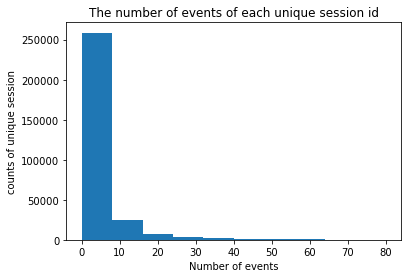

In [6]:
# Event per unique session id
sid_event_counts = train.groupby('session').count()['aid'].to_list()
plt.title('The number of events of each unique session id')
plt.hist(sid_event_counts, range=[0,80])
print('Most sessions have less than 10 events.')
plt.xlabel('Number of events')
plt.ylabel('counts of unique session')

Most sessions had all their events happening within 1 day.


Text(0, 0.5, 'counts of unique session')

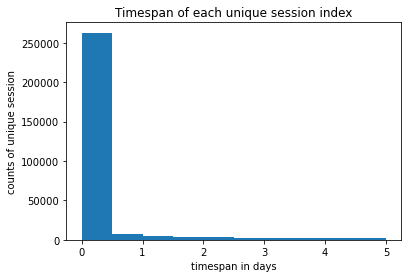

In [7]:
# Find timespan of each session
def ts_minmax(df):
    min_ts = df['ts'].min()
    max_ts = df['ts'].max()
    return max_ts - min_ts

timespans = train.groupby('session').apply(lambda df: ts_minmax(df))
timespans = timespans / (24 * 60 * 60 * 1000)
plt.title('Timespan of each unique session index')
plt.hist(timespans, range=[0,5])
print('Most sessions had all their events happening within 1 day.')
plt.xlabel('timespan in days')
plt.ylabel('counts of unique session')

Most items did not appear for more than 100 times.


Text(0, 0.5, 'Counts of unique item')

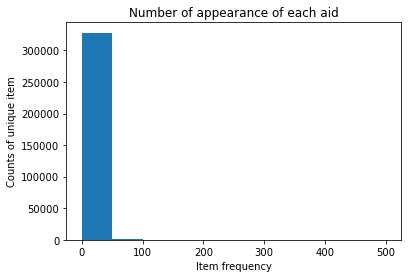

In [8]:
# How frequent each aid showed up 
aid_counts = train.groupby('aid').count()['session']
plt.hist(aid_counts, range=[0,500])
plt.title('Number of appearance of each aid')
print('Most items did not appear for more than 100 times.')
plt.xlabel('Item frequency')
plt.ylabel('Counts of unique item')

The 30% most frequent items associated with 70% events.


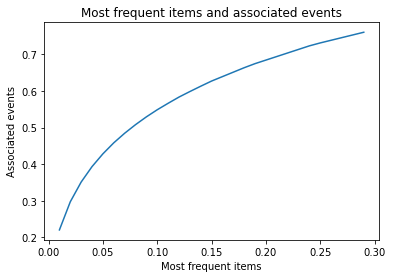

In [9]:
# How about the most frequent 1% events
percs = np.arange(0.01, 0.3, 0.01)
accum_percs = list()
for perc in percs:
    most_frequent = int(np.floor(n_aid * perc))
    importance = aid_counts.nlargest(most_frequent).sum() / train.shape[0]
    accum_percs.append(importance)

plt.plot(percs, accum_percs)
plt.xlabel('Most frequent items')
plt.ylabel('Associated events')
plt.title('Most frequent items and associated events')
print('The 30% most frequent items associated with 70% events.')

Text(0, 0.5, 'Counts of unique session index')

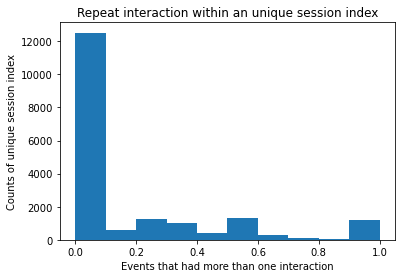

In [10]:
# How often each session interacted with an item more than once
def count_repeat_aid(df):
    counter = df.groupby('aid').count()['session']
    return sum(counter > 1) / len(counter)

repeat_interaction = train.iloc[:100000].groupby('session').apply(lambda df: count_repeat_aid(df))
plt.title('Repeat interaction within an unique session index')
plt.hist(repeat_interaction)
plt.xlabel('Events that had more than one interaction')
plt.ylabel('Counts of unique session index')

(0.0, 1.0)

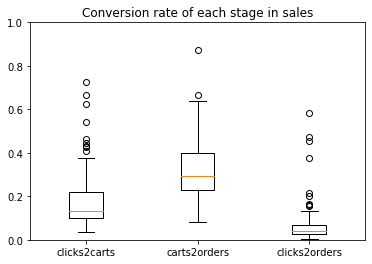

In [11]:
# Conversion rates of each aid

# Find the most frequent purchases items
n_most_frequent = 100
aid_counts = train[train['type'] == 'orders'].groupby('aid').count()['session'].nlargest(n_most_frequent)
filtered = train[train['aid'].isin(aid_counts.index)]

def cal_conversion_rates(df, stage):
    counts = df.groupby('type').count()['session']
    if stage == 'clicks2orders':
        return counts['orders'] / counts['clicks']
    if stage =='clicks2carts':
        return counts['carts'] / counts['clicks']
    if stage =='carts2orders':
        return counts['orders'] / counts['carts']

c1 = filtered.groupby('aid').apply(lambda df: cal_conversion_rates(df, stage='clicks2orders')).to_list()
c2 = filtered.groupby('aid').apply(lambda df: cal_conversion_rates(df, stage='clicks2carts')).to_list()
c3 = filtered.groupby('aid').apply(lambda df: cal_conversion_rates(df, stage='carts2orders')).to_list()


log = {
    'clicks2carts': c2,
    'carts2orders': c3,
    'clicks2orders': c1,
}

fig,ax = plt.subplots()
ax.boxplot(log.values())
ax.set_xticklabels(log.keys())
plt.title('Conversion rate of each stage in sales')
ax.set_ylim(0, 1)

# Models

Metric: Recall@20, weights by each event type

Baseline:
1. Most frequent items
2. Most frequent items of each sessoin index

Strategy:
1. Using each session's 20 most frequent items as predictions.
2. For each session, if there are less than 20 interacted items, then padding.
3. Experiments with different approaches of padding

Padding approaches:
1. Most frequent items in the whole train dataset
2. Using merged2counters to find the most relevant items
3. Cosine similarity
4. Jacard similarity

In [12]:
# Baseline1: Most frequent items
otto.baseline()

Using candidates, themost frequent items, as predictions ...
Calculating recall20 ...


339597it [00:09, 35256.14it/s]


Final recall score: 0.003570


In [13]:
# Baseline2: Interacted items of each session index
def df2preds(df):
    ls_aid = df['aid'].to_list()
    counter = Counter(ls_aid).most_common(20)
    ls_aid = [aid for (aid,counts) in counter]
    ls_aid = [str(aid) for aid in ls_aid]
    return ' '.join(ls_aid)

def preds_add_suffix(preds):
    ls_suffix = ['_clicks', '_carts', '_orders']
    ls_dfs = list()
    for suf in ls_suffix:
        ls_dfs.append(pd.DataFrame(preds.add_suffix(suf), columns=['labels']).reset_index())

    # Combine predictions for each type
    mapping = {'session': 'session_type'}
    sub = pd.concat(ls_dfs).sort_values('session').rename(columns=mapping).reset_index(drop=True)
    return sub

In [14]:
# Generate predictions
preds = val.groupby('session').apply(lambda df: df2preds(df))
sub = preds_add_suffix(preds)
otto.from_sub_to_recall20(sub)

Calculating recall20 ...


339597it [00:09, 36019.70it/s]

Final recall score: 0.472596


In [15]:
# Padding approach 1: Most frequent items in the train dataset
def df2preds_candidates(df, candidates):
    ls_aid = df['aid'].to_list()
    counter = Counter(ls_aid).most_common(20)
    ls_aid = [aid for (aid,counts) in counter]
    if len(ls_aid) == 20:
        ls_aid = [str(aid) for aid in ls_aid]
        return ' '.join(ls_aid)
    else:
        n_padding = 20 - len(ls_aid)
        ls_aid += candidates[:n_padding]
        ls_aid = [str(aid) for aid in ls_aid]
        return ' '.join(ls_aid)

In [16]:
# Generate predictions
preds = val.groupby('session').apply(lambda df: df2preds_candidates(df, candidates))
sub = preds_add_suffix(preds)
otto.from_sub_to_recall20(sub)

Calculating recall20 ...


339597it [00:09, 35229.86it/s]

Final recall score: 0.473678


In [17]:
# Padding approach 2: Using merged2counters to find the most relevant items
pickle_path = '/Users/linshoahchieh/Documents/Kaggle/Otto_recommender_system/data/merged2counters.pickle'
with open(pickle_path, 'rb') as file:
    main_counter = pickle.load(file)

In [18]:
def df2preds_counter(df, main_counter):
    ls_aid = df['aid'].to_list()
    counter = Counter(ls_aid).most_common(20)
    ls_aid = [aid for (aid,counts) in counter]
    if len(ls_aid) == 20:
        ls_aid = [str(aid) for aid in ls_aid]
        return ' '.join(ls_aid)
    else:
        cum_counter = Counter()
        for aid in ls_aid:
            try:
                cum_counter += main_counter[aid]
            except:
                pass

        n_padding = 20 - len(ls_aid)
        paddings = [aid for (aid,counts) in cum_counter.most_common(n_padding)]
        ls_aid += paddings
        ls_aid = [str(aid) for aid in ls_aid]
        return ' '.join(ls_aid)

In [19]:
# Generate predictions
preds = val.groupby('session').apply(lambda df: df2preds_counter(df, main_counter))
sub = preds_add_suffix(preds)
otto.from_sub_to_recall20(sub)

Calculating recall20 ...


339597it [00:09, 34802.47it/s]

Final recall score: 0.517137


In [20]:
# Padding approach 3: Cosine similiarity
np.random.seed(2023)
n_candidates = 1000
cands = train.groupby('aid').count()['session'].nlargest(n_candidates).index

n_sid_for_training = 500000
random_sids = np.random.choice(train['session'].unique(), n_sid_for_training)
train_red = train[(train['session'].isin(random_sids)) & (train['aid'].isin(cands))]
print(train.shape)
print(train_red.shape)

(1359885, 4)
(137364, 4)


In [67]:
def generate_fm(train):
    sid2index = {sid:eid for eid,sid in enumerate(train['session'].unique())}
    aid2index = {aid:eid for eid,aid in enumerate(train['aid'].unique())}

    # generate inverse dictionary for later usage
    index2aid = {idx:aid for aid,idx in aid2index.items()}

    n_unique_session = train['session'].nunique()
    n_unique_aid = train['aid'].nunique()
    fm = np.zeros(shape=(n_unique_session, n_unique_aid))

    # fill up fm
    for i,row in tqdm(train.iterrows()):
        s_index = sid2index[row['session']]
        a_index = aid2index[row['aid']]
        fm[s_index, a_index] = 1

    return fm,sid2index,aid2index,index2aid

# Using cossim for padding
def df2preds_simmatrix(df, sm, aid2index, index2aid, candidates):
    ls_aid = df['aid'].to_list()
    counter = Counter(ls_aid).most_common(20)
    ls_aid = [aid for (aid,counts) in counter]
    if len(ls_aid) == 20:
        ls_aid = [str(aid) for aid in ls_aid]
        return ' '.join(ls_aid)
    else:
        n_padding = 20 - len(ls_aid)
        ls_sim = list()
        for i,row in df.iterrows():
            try:
                a_index = aid2index[row['aid']]
                ls_sim.append(sm[a_index])
            except:
                pass
        
        if ls_sim:
            importance = np.sum(np.vstack(ls_sim), axis=0)
            a_indices = np.argsort(importance)[-n_padding:]

            # from a_indices to aid
            for a_index in a_indices:
                ls_aid.append(index2aid[a_index])

        else: #nothing in the ls_sim, so padding with candidates
            n_padding = 20 - len(ls_aid)
            ls_aid += candidates[:n_padding]

        ls_aid = [str(aid) for aid in ls_aid]
        return ' '.join(ls_aid)

In [68]:
#Generate feature matrix
fm,sid2index,aid2index,index2aid = generate_fm(train_red)

# Calculate cosine similarity
dot_products = fm.T.dot(fm)
norm_per_row = np.sqrt(np.sum(fm**2, axis=0))
xx,yy = np.meshgrid(norm_per_row, norm_per_row)
cossim = dot_products / (xx * yy)
print(cossim.shape)

137364it [00:03, 37994.29it/s]


(1000, 1000)


In [69]:
# Generate predictions
preds = val.groupby('session').apply(lambda df: df2preds_simmatrix(df, cossim, aid2index, index2aid, candidates))
sub = preds_add_suffix(preds)
otto.from_sub_to_recall20(sub)

Calculating recall20 ...


339597it [00:09, 34617.24it/s]

Final recall score: 0.480536


In [24]:
# Padding approach 4: Jaccob similiarity
# Using the same train_red as padding approach 3 to generate feature matrix
print(train.shape)
print(train_red.shape)

#Generate feature matrix
fm,sid2index,aid2index,index2aid = generate_fm(train_red)

# Calculate jaccob similarity
interaction = fm.T.dot(fm)
sum_per_col = np.sum(fm, axis=0)
xx,yy = np.meshgrid(sum_per_col, sum_per_col)
union = xx + yy - interaction
jsim = interaction / union
print(jsim.shape)

(1359885, 4)
(137364, 4)


137364it [00:03, 37478.38it/s]


(1000, 1000)


In [66]:
# Generate predictions
preds = val.groupby('session').apply(lambda df: df2preds_simmatrix(df, jsim, aid2index, index2aid, candidates))
sub = preds_add_suffix(preds)
otto.from_sub_to_recall20(sub)

Calculating recall20 ...


339597it [00:09, 35336.31it/s]

Final recall score: 0.480451


In [183]:
experiments = ['baseline#1', 'baseline#2', 'padding#1', 'padding#2', 'padding#3', 'padding#4', 'winners model']
data = {
    'recall@20': [0.003570, 0.472596, 0.473678, 0.517137, 0.480536, 0.480451, 0.60],
    'c':['gray','gray','gray','gray','gray','gray','orange']
}

recalls = pd.DataFrame(
                    index = experiments,
                    data = data,
                    )

recalls

,recall@20,c
baseline#1,0.003570,gray
baseline#2,0.472596,gray
padding#1,0.473678,gray
padding#2,0.517137,gray
padding#3,0.480536,gray
padding#4,0.480451,gray
winners model,0.600000,orange


Text(0.5, 1.0, 'Model Performance')

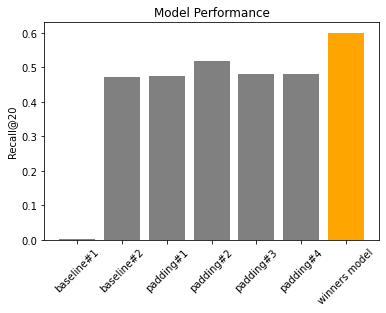

In [184]:
import matplotlib.pyplot as plt
plt.bar(recalls.index, recalls['recall@20'], color=recalls['c'])
plt.xticks(rotation=45)
plt.ylabel('Recall@20')
plt.title('Model Performance')